# Imports

In [1]:
import warnings

import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
import uproot
from IPython.display import clear_output
from itables import init_notebook_mode
from matplotlib.ticker import AutoMinorLocator, MaxNLocator
from scipy import stats
from skimage.measure import LineModelND, ransac
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression, RANSACRegressor
from skspatial.objects import Cylinder, Line
from tqdm.auto import tqdm, trange

init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

# Parameters

In [2]:
min_samples = 2
xy_epsilon = 8  # 8 ideal
z_epsilon = 8  # 8 ideal

# Cylinder parameters for dQ/dx
min_dA = np.sqrt(xy_epsilon**2 + z_epsilon**2) / 4
dh = np.sqrt(xy_epsilon**2 + z_epsilon**2) / 2

# RANSAC parameters
residual_threshold = 6  # 6 ideal
max_trials = 1000

# File loading

In [3]:
with uproot.open("rwf_0cd913fa_20230706_191437.data_array.root") as f:
    tree = f["rwf_array"]
    light_df = pd.DataFrame()
    for idx, arrays in enumerate(tree.iterate(library="np")):
        # print(idx)
        df = pd.DataFrame.from_dict(arrays, orient="index").T
        light_df = pd.concat([light_df, df], ignore_index=True)

In [4]:
with uproot.open("evd_self_trigger-packets-2023_07_06_19_14_CEST.root") as f:
    charge_df = f["events"].arrays(library="pd").set_index("eventID")

event_start_t  event_end_t  event_duration  event_unix_ts  \
eventID                                                              
0                 6745        25989           19244     1688663701   
1                35396        39030            3634     1688663686   
2                41414        47314            5900     1688663697   
3               108020       109246            1226     1688663695   
4               131826       134138            2312     1688663700   
...                ...          ...             ...            ...   
6036           9901507      9902946            1439     1688664261   
6037           9910196      9910664             468     1688664259   
6038           9951013      9953508            2495     1688664247   
6039           9966517      9976635           10118     1688664247   
6040           9993737      9995239            1502     1688664249   

         event_nhits       event_q   event_q_raw  event_ntracks  \
eventID                                                           
0                383 -20383.220703 -20383.220703              0   
1                 79  -4609.645020  -4609.645020              0   
2                  3   -626.695923   -626.695923              0   
3                 20  -1022.497192  -1022.497192              0   
4                 12   -896.481323   -896.481323              0   
...              ...           ...           ...            ...   
6036              12   -478.771881   -478.771881              0   
6037              57  -2887.122314  -2887.122314              0   
6038               7   -883.013855   -883.013855              0   
6039              35  -2568.037109  -2568.037109              0   
6040              65  -3259.577881  -3259.577881              0   

         event_n_ext_trigs                                       event_hits_x  \
eventID                                                                         
0                       20  [6.0, 30.0, 26.0, 26.0, 30.0, 6.0, 30.0, 30.0,...   
1                        7  [-34.0, -38.0, -34.0, -38.0, -34.0, -58.0, -50...   
2                        7                                  [0.0, 0.0, -42.0]   
3                        3  [58.0, 58.0, 62.0, 62.0, 58.0, 58.0, 38.0, 62....   
4                        5  [14.0, 14.0, 18.0, 14.0, 18.0, 6.0, 14.0, 18.0...   
...                    ...                                                ...   
6036                     2  [30.0, 22.0, 26.0, 30.0, 22.0, 6.0, 26.0, 30.0...   
6037                     1  [46.0, 46.0, 46.0, 46.0, 38.0, 50.0, 50.0, 54....   
6038                     4       [-58.0, -58.0, -54.0, 0.0, 54.0, 0.0, -42.0]   
6039                     7  [-58.0, -38.0, -38.0, -38.0, -42.0, -58.0, -42...   
6040                     1  [34.0, 62.0, -6.0, -58.0, -34.0, -30.0, -62.0,...   

         ...                                       event_hits_q  \
eventID  ...                                                      
0        ...  [-59.77073287963867, -41.35984420776367, -50.6...   
1        ...  [-53.43817138671875, -64.73534393310547, 3.751...   
2        ...               [-292.0, -292.0, -42.69593048095703]   
3        ...  [-63.173728942871094, -58.830528259277344, -64...   
4        ...  [-47.4110107421875, -16.122285842895508, -61.1...   
...      ...                                                ...   
6036     ...  [-57.14545822143555, -58.1761474609375, -57.44...   
6037     ...  [-59.48933792114258, -13.310519218444824, -42....   
6038     ...  [-60.70035934448242, -63.66340637207031, -53.6...   
6039     ...  [-57.8087158203125, -69.85416412353516, -7.515...   
6040     ...  [-62.376434326171875, -64.01460266113281, -62....   

                                       event_hits_io_group  \
eventID                                                      
0        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2                                                [1,

# File verification

In [5]:
charge_df.columns

Index(['event_start_t', 'event_end_t', 'event_duration', 'event_unix_ts',
       'event_nhits', 'event_q', 'event_q_raw', 'event_ntracks',
       'event_n_ext_trigs', 'event_hits_x', 'event_hits_y', 'event_hits_z',
       'event_hits_ts', 'event_hits_q', 'event_hits_io_group',
       'event_hits_chipid', 'event_hits_channelid', 'event_hits_io_channel',
       'event_hits_global_id', 'trigID', 'trig_type', 'trig_time',
       'trig_eventID'],
      dtype='object')

In [6]:
light_df.columns

In [7]:
# light_df[(light_df["event"] == 19) & (light_df["ch"] == 5)]["rwf"]

# Offset correction

In [8]:
# Charge correction
global_q_offset = charge_df["event_hits_q"].apply(tuple).explode().min()
charge_df["event_hits_q"] = charge_df["event_hits_q"] - global_q_offset
charge_df["event_q"] = charge_df["event_hits_q"].apply(sum)
print(global_q_offset)

In [9]:
# Z correction
global_z_min = charge_df["event_hits_z"].apply(tuple).explode().min()
global_z_max = charge_df["event_hits_z"].apply(tuple).explode().max()
print(global_z_max, global_z_min)

2383.92724609375 -320.0


# Histograms

Trigger time distribution


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


<Axes: >

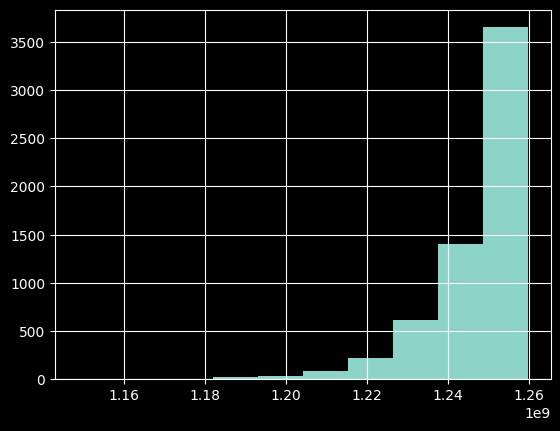

In [10]:
print("Trigger time distribution")
charge_df["trig_time"].apply(np.mean).hist()

Event duration in ns


<Axes: >

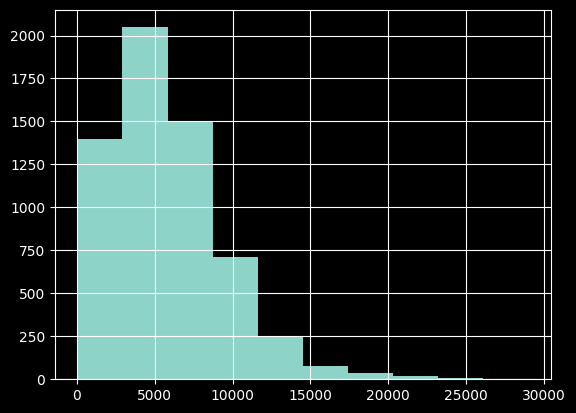

In [11]:
print("Event duration in ns")
charge_df["event_duration"].hist()

Charge per hit in ?


<Axes: >

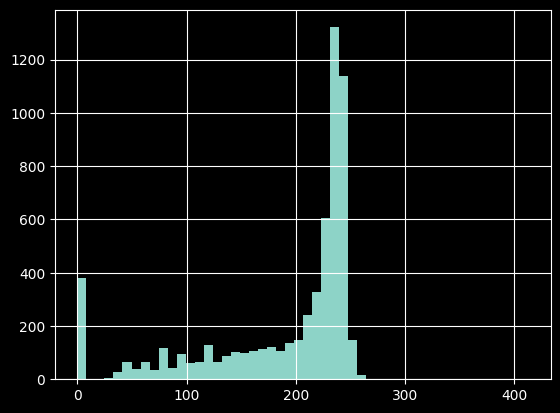

In [12]:
print("Charge per hit in ?")
(charge_df["event_q"] / charge_df["event_nhits"]).hist(bins=50)

Charge per hit per event in ?


<Axes: xlabel='eventID', ylabel='0'>

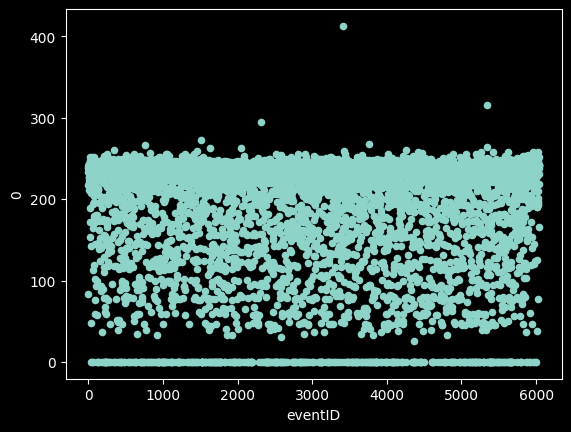

In [13]:
print("Charge per hit per event in ?")
(charge_df["event_q"] / charge_df["event_nhits"]).to_frame().reset_index().plot.scatter(
    x="eventID", y=0
)

Event charge in ?


<Axes: >

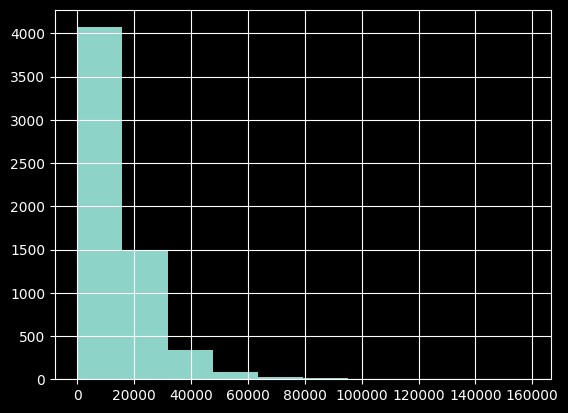

In [14]:
print("Event charge in ?")
charge_df["event_q"].hist()

Hits z in ?


<Axes: >

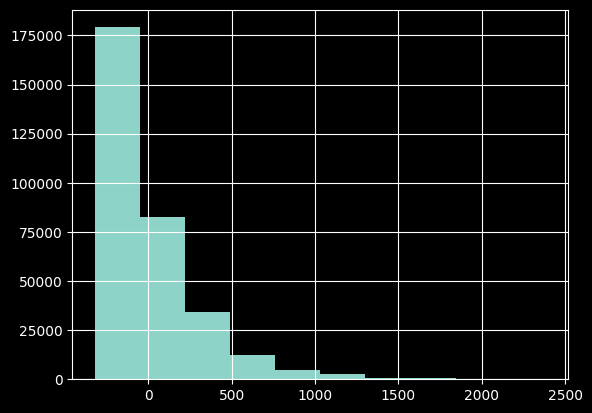

In [15]:
print("Hits z in ?")
charge_df["event_hits_z"].apply(tuple).explode().hist()

Hits q in ?


<Axes: >

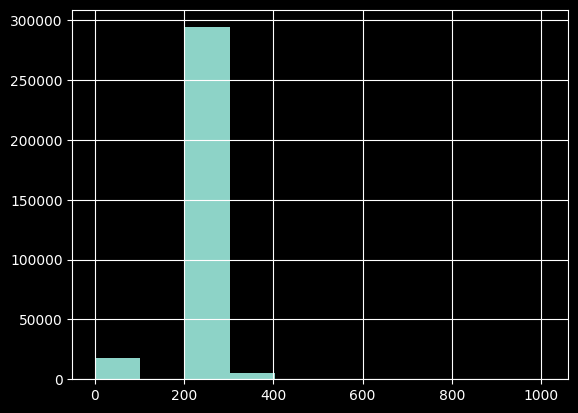

In [16]:
print("Hits q in ?")
charge_df["event_hits_q"].apply(tuple).explode().hist()

# Functions

In [40]:
# Create a list of holes
def generate_dead_area(z_range):
    # Dead area on chips 44, 54, 64
    fake_x1, fake_y1, fake_z1 = np.meshgrid(
        np.linspace(36, 60, 6),
        np.concatenate(
            [
                np.linspace(-76, -52, 6),
                np.linspace(-44, -20, 6),
                np.linspace(-12, 12, 6),
            ]
        ),
        z_range,
    )

    # Dead area on chip 33
    fake_x2, fake_y2, fake_z2 = np.meshgrid(
        np.linspace(4, 28, 6), np.linspace(20, 44, 6), z_range
    )

    # Dead area on chip 42
    fake_x3, fake_y3, fake_z3 = np.meshgrid(
        np.linspace(-28, -4, 6), np.linspace(-12, 12, 6), z_range
    )
    mask = fake_x3 + (fake_y3 + 16) <= 0
    fake_x3, fake_y3, fake_z3 = fake_x3[mask], fake_y3[mask], fake_z3[mask]

    # Dead area on SiPMs
    fake_x4 = []
    fake_y4 = []
    fake_z4 = []
    for k in range(4):
        for l in range(5):
            if (k == 3 and l < 3) or (k == 2 and l == 3):
                continue

            temp_x, temp_y, temp_z = np.meshgrid(
                np.array([-50, -46]) + 32 * k,
                np.array([-66, -62]) + 32 * l,
                z_range,
            )
            fake_x4.extend(temp_x)
            fake_y4.extend(temp_y)
            fake_z4.extend(temp_z)

    # Concatenate all the fake data
    fake_x = np.concatenate(
        [
            fake_x1.flatten(),
            fake_x2.flatten(),
            fake_x3.flatten(),
            np.array(fake_x4).flatten(),
        ]
    )
    fake_y = np.concatenate(
        [
            fake_y1.flatten(),
            fake_y2.flatten(),
            fake_y3.flatten(),
            np.array(fake_y4).flatten(),
        ]
    )
    fake_z = np.concatenate(
        [
            fake_z1.flatten(),
            fake_z2.flatten(),
            fake_z3.flatten(),
            np.array(fake_z4).flatten(),
        ]
    )

    fake_data = np.c_[fake_x, fake_y, fake_z]

    return fake_data


# Apply DBSCAN clustering
def cluster(hitArray):
    # First stage clustering
    z_intervals = []
    first_stage = DBSCAN(eps=xy_epsilon, min_samples=min_samples).fit(hitArray[:, 0:2])
    for label in first_stage.labels_:
        if label > -1:
            mask = first_stage.labels_ == label
            z = hitArray[mask, 2]
            z_intervals.append((min(z), max(z)))

    # Sort the intervals based on their start points
    sorted_intervals = sorted(z_intervals, key=lambda interval: interval[0])

    # Initialize a list to store the intervals representing the empty space
    empty_space_ranges = []

    # Iterate through the sorted intervals to find the gaps
    for i in range(len(sorted_intervals) - 1):
        current_interval = sorted_intervals[i]
        next_interval = sorted_intervals[i + 1]

        # Calculate the gap between the current interval and the next interval
        gap_start = current_interval[1]
        gap_end = next_interval[0]

        # Check if there is a gap (empty space) between intervals
        if gap_end > gap_start and gap_end < gap_start + 40:
            empty_space_ranges.append(np.arange(gap_start, gap_end, z_epsilon))

    if not empty_space_ranges:
        empty_space_ranges.append(
            np.arange(
                np.mean(hitArray[:, 2]) - np.std(hitArray[:, 2]),
                np.mean(hitArray[:, 2]) + np.std(hitArray[:, 2]),
                z_epsilon,
            )
        )

    z_range = np.concatenate(empty_space_ranges)

    # Create a list of holes
    fake_data = generate_dead_area(z_range)
    fake_data_count = len(fake_data)

    # Second stage clustering
    # Combine fake to true data
    second_stage_data = np.concatenate([hitArray, fake_data])
    second_stage = DBSCAN(eps=xy_epsilon, min_samples=1).fit(second_stage_data[:, 0:2])

    # Third stage clustering
    # Create a new array with z and labels
    third_stage_z = np.c_[second_stage.labels_ * 1e3, second_stage_data[:, 2]]
    flag = second_stage.labels_ > -1
    third_stage_data = third_stage_z[flag].copy()
    third_stage = DBSCAN(
        eps=z_epsilon, min_samples=min_samples, metric="chebyshev"
    ).fit(third_stage_data)

    # Remove fake data
    # Shift labels by 1 so that negative values are reserved for outliers
    labels = third_stage.labels_[:-fake_data_count] + 1

    return labels


# Apply Ransac Fit
def ransacFit(hitArray, weightArray=None):
    if weightArray is not None:
        estimator = RANSACRegressor(
            min_samples=min_samples,
            max_trials=max_trials,
            residual_threshold=residual_threshold,
        )
        inliers = estimator.fit(
            hitArray[:, 0:2],
            hitArray[:, 2],
            sample_weight=weightArray,
        ).inlier_mask_

        score = estimator.score(hitArray[:, 0:2], hitArray[:, 2])
    else:
        model_robust, inliers = ransac(
            hitArray,
            LineModelND,
            min_samples=min_samples,
            residual_threshold=residual_threshold,
            max_trials=max_trials,
        )

        score = model_robust.score(hitArray)

    outliers = inliers == False
    return inliers, outliers, score


# Apply best line fit
def lineFit(hitArray):
    line = Line.best_fit(hitArray)
    residuals = []
    for point in hitArray:
        distance = line.distance_point(point)
        residuals.append(distance)

    # Convert residuals to a numpy array
    residuals = np.array(residuals)

    # Calculate chi-squared
    chi_squared = np.sum(residuals**2)

    return line, chi_squared


# Calculate dQ/dx from a line fit
def dqdx(hitArray, q, line_fit, dh, dA, h, ax=None):
    # Cylinder step size for dQ/dx
    steps = np.arange(-2 * dh, h + 3 * dh, dh)

    # Mask of points that have been accounted for
    counted = np.zeros(len(q), dtype=bool)

    # Array of dQ values for each step
    dq_i = np.zeros(len(steps), dtype=float)

    for step_idx, step in enumerate(steps):
        cylinder_fit = Cylinder(
            line_fit.to_point(h / 2 - step),
            -line_fit.direction.unit() * dh,
            dA,
        )
        if ax is not None:
            cylinder_fit.plot_3d(ax)

        for point_idx, point in enumerate(hitArray):
            if not counted[point_idx] and cylinder_fit.is_point_within(point):
                counted[point_idx] = True
                dq_i[step_idx] += q[point_idx]

    return dq_i


# Fit clusters with Ransac method
def fitClusters(hitArray, q, labels, ax2d, ax3d, plot_cyl=False, refit_outliers=True):
    # Create a dictionary of lines
    lines = {}
    # Create a dictionary of p-values
    p_values = {}
    # Create a dictionary of scores
    scores = {}
    # Create a dictionary of dq
    dq = {}

    # Fit clusters
    idx = 0
    condition = lambda: idx < len(np.unique(labels))
    while condition():
        label = np.unique(labels)[idx]
        mask = labels == label
        if label > 0 and mask.sum() > min_samples:
            XYZ_c = hitArray[mask]
            x_c, y_c, z_c = XYZ_c[:, 0], XYZ_c[:, 1], XYZ_c[:, 2]
            q_c = np.array(q)[mask]

            norm = np.linalg.norm(
                [
                    x_c.max() - x_c.min(),
                    y_c.max() - y_c.min(),
                    z_c.max() - z_c.min(),
                ]
            )

            # Fit the model
            inliers, outliers, score = ransacFit(XYZ_c, q_c - min(q_c) + 1)
            scores[label] = score

            # Refit outliers
            level_1 = np.where(mask)[0]
            level_2 = np.where(outliers)[0]
            level_3 = level_1[level_2]

            if refit_outliers and sum(outliers) > min_samples:
                outlier_labels = cluster(XYZ_c[outliers])
                last_label = max(labels) + 1
                # Assign positive labels to clustered outliers and negative labels to unlclustered outliers
                for i, j in enumerate(level_3):
                    labels[j] = (outlier_labels[i] + last_label) * (
                        1 if outlier_labels[i] > 0 else -1
                    )
            else:
                # Assign negative labels to outliers
                for j in level_3:
                    labels[j] = -labels[j]

            if sum(inliers) > min_samples:
                line_fit, chi_squared = lineFit(XYZ_c[inliers])
                # Degrees of freedom (number of points - number of parameters in the line fit)
                degrees_of_freedom = sum(inliers) - 1
                # Calculate the reduced chi squared
                reduced_chi_squared = chi_squared / degrees_of_freedom
                # Calculate the p-value (assuming chi-squared distribution)
                p_value = 1 - stats.chi2.cdf(chi_squared, degrees_of_freedom)

                lines[label] = line_fit
                p_values[label] = p_value

                if ax2d is not None:
                    # 2D plot
                    line_fit.plot_2d(
                        ax2d,
                        t_1=-norm / 2,
                        t_2=norm / 2,
                        c="red",
                        label="Fit",
                        zorder=10,
                    )
                if ax3d is not None:
                    # 3D plot
                    line_fit.plot_3d(
                        ax3d, t_1=-norm / 2, t_2=norm / 2, c="red", label="Fit"
                    )

                # Calculate dQ/dx
                dA = max(np.sqrt(reduced_chi_squared), min_dA)
                dq_i = dqdx(
                    XYZ_c[inliers],
                    q_c[inliers],
                    line_fit,
                    dh=dh,
                    dA=dA,
                    h=norm,
                    ax=ax3d if ax3d is not None and plot_cyl else None,
                )

                if dq_i.sum() != 0:
                    dq[label] = dq_i
                else:
                    dq[label] = 0

        idx += 1

    metrics = {
        "DBSCAN_labels": labels,
        "Fit_lines": lines,
        "Fit_p_values": p_values,
        "RANSAC_scores": scores,
        "dQ": dq,
    }

    return metrics

In [41]:
def create_axes(event_idx, charge):
    fig = plt.figure(figsize=(12, 6))
    ax3d = fig.add_subplot(121, projection="3d")
    ax2d = fig.add_subplot(122)
    fig.suptitle(f"Event {event_idx} - Charge = {charge} ?")

    # Draw dead areas
    for i in range(4):
        j = 0
        if i == 3:
            j = 1
        ax2d.plot(
            np.arange(32, 64 + 1, 1) - 32 * j,
            np.arange(-80, -48 + 1, 1) + 32 * i,
            c="white",
            lw=1,
        )
        ax2d.plot(
            np.arange(64, 32 - 1, -1) - 32 * j,
            np.arange(-80, -48 + 1, 1) + 32 * i,
            c="white",
            lw=1,
        )

    # ax2d.plot(np.linspace(-31,0),np.linspace(8,-16), c="white",lw = 1)
    ax2d.plot(np.linspace(-32, 0), np.linspace(16, -16), c="white", lw=1, zorder=-1)
    ax2d.plot(np.linspace(-32, -16), np.linspace(-16, 0), c="white", lw=1, zorder=-1)

    # Adjust axes
    for ax in [ax3d, ax2d]:
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim([-64, 64])
        ax.set_ylim([-80, 80])
        ax.set_xlabel("x [mm]")
        ax.set_ylabel("y [mm]")
        ax.set_xticks(np.linspace(-64, 64, 5))
        ax.set_yticks(np.linspace(-80, 80, 6))
        ax.xaxis.set_minor_locator(AutoMinorLocator(8))
        ax.yaxis.set_minor_locator(AutoMinorLocator(8))
        ax.grid()

    # Adjust z-axis
    ax3d.set_zlabel("z [?]")
    ax3d.zaxis.set_minor_locator(AutoMinorLocator(8))
    ax3d.zaxis.set_major_locator(MaxNLocator(integer=True))

    return fig, (ax2d, ax3d)


def event_display(event_idx, x, y, z, t, q, plot_cyl=False, plot_line=True):
    if len(x) < 2:
        return None, None, None, None, None

    # Plot the hits
    fig, axes = create_axes(event_idx, round(sum(q)))
    ax2d = axes[0]
    ax3d = axes[1]

    # Group by x and y coordinates and sum the z values
    data2d = np.c_[x, y, q]
    unique_points, indices = np.unique(data2d[:, :2], axis=0, return_inverse=True)
    q_sum = np.bincount(indices, weights=data2d[:, 2])

    # Plot the hits
    plot3d = ax3d.scatter(
        x, y, z, c=q, marker="s", s=20, vmin=q_sum.min(), vmax=q_sum.max()
    )
    plot2d = ax2d.scatter(
        unique_points[:, 0],
        unique_points[:, 1],
        c=q_sum,
        marker="s",
        s=30,
        vmin=q_sum.min(),
        vmax=q_sum.max(),
    )
    cbar = plt.colorbar(plot2d)
    cbar.set_label("charge [?]")

    # Create a design matrix
    XYZ = np.c_[x, y, z]

    # Cluster the hits
    labels = cluster(XYZ)

    # Fit clusters
    metrics = fitClusters(XYZ, q, labels, ax2d, ax3d, plot_cyl)

    # Draw the SIPMs
    for k in range(4):
        for l in range(5):
            vertices_x = np.array([-51, -51, -45, -45, -51])
            vertices_y = np.array([-67, -61, -61, -67, -67])
            ax2d.fill(k * 32 + vertices_x, l * 32 + vertices_y, c="white", zorder=5)

    # ax3d.view_init(160, 110, -85)
    ax3d.view_init(30, 20, 100)
    # ax3d.view_init(0, 0, 0)
    # ax3d.view_init(0, 0, 90)
    fig.tight_layout()

    fig.savefig(f"event_{event_idx}.png", dpi=300)
    # plt.show()

    return metrics

# Event display

## Fake data map

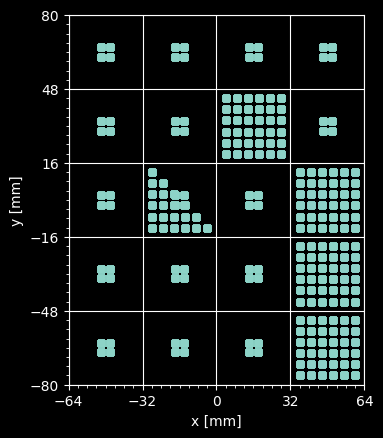

In [19]:
fake_data = generate_dead_area(np.arange(-300, 0, 10))
fake_x, fake_y, fake_z = fake_data[:, 0], fake_data[:, 1], fake_data[:, 2]

fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_aspect("equal", adjustable="box")
ax.scatter(fake_x, fake_y, marker="s", s=20)
ax.set_xlim([-64, 64])
ax.set_ylim([-80, 80])
ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
ax.set_xticks(np.linspace(-64, 64, 5))
ax.set_yticks(np.linspace(-80, 80, 6))
ax.xaxis.set_minor_locator(AutoMinorLocator(8))
ax.yaxis.set_minor_locator(AutoMinorLocator(8))
ax.grid()
plt.show()

## Real data + fit

In [20]:
# Suppress the UndefinedMetricWarning
warnings.filterwarnings("ignore", category=Warning)

  0%|          | 0/6041 [00:00<?, ?it/s]

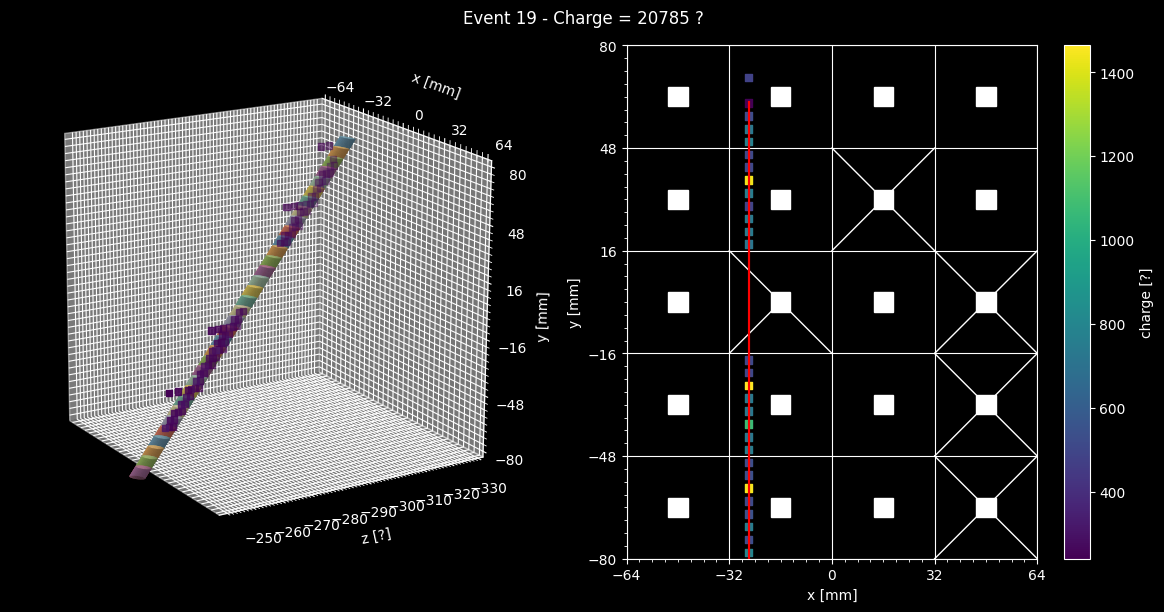

In [42]:
metrics = {}
# x_list = []
# y_list = []
# z_list = []
# t_list = []
# q_list = []

# event_list = np.array(sorted([19, 33]))
event_list = np.arange(19, 20, 1)
for idx, row in tqdm(charge_df.iterrows(), total=len(charge_df)):
    if idx not in event_list:
        continue
    if idx > event_list.max():
        break

    x = np.array(row["event_hits_x"])
    y = np.array(row["event_hits_y"])
    z = np.array(row["event_hits_z"])
    t = np.array(row["event_hits_ts"])
    q = np.array(row["event_hits_q"])

    non_zero_indices = (x != 0) * (y != 0)

    # Apply boolean indexing to x, y, and z arrays
    x = x[non_zero_indices]
    y = y[non_zero_indices]
    z = z[non_zero_indices]
    t = t[non_zero_indices]
    q = q[non_zero_indices]

    # x_list.extend(x)
    # y_list.extend(y)
    # z_list.extend(z)
    # t_list.extend(t)
    # q_list.extend(q)

    if len(x) > 2:
        metrics[idx] = event_display(
            idx,
            x,
            y,
            z,
            t,
            q,
            plot_cyl=True,
        )
        plt.show()
        # plt.close()

    else:
        print("Not enough hits to fit")

# _,_,_ = event_display("All", x_list, y_list, z_list, t_list, q_list)

In [ ]:
# Reset the warning filter (optional)
warnings.filterwarnings("default", category=Warning)

## Metrics

In [43]:
metrics

{19: {'DBSCAN_labels': array([ 1,  1,  1,  1,  1,  1,  1,  1,  1, -2,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -2,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1, -2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -2,  1,  1]),
  'Fit_lines': {1: Line(point=Point([ -26.        ,  -11.11392405, -287.14186656]), direction=Vector([ 0.        ,  0.91810206, -0.39634405]))},
  'Fit_p_values': {1: 3.7442215994332173e-10},
  'RANSAC_scores': {1: 0.9928709168615188},
  'dQ': {1: array([   0.        ,    0.        ,  762.23678589,  728.58734131,
           775.0675354 , 1017.20462036,  976.77409363,  755.48371887,
           948.23751831, 1022.14068604,  723.32550049,    0.        ,
             0.        ,    0.        ,    0.        ,    0.        ,
             0.        ,  506.58624268,  979.99411011, 1241.90977478,
     

# dQ/dx

In [46]:
np.sum(metrics[19]["dQ"][1])

18898.41697692871

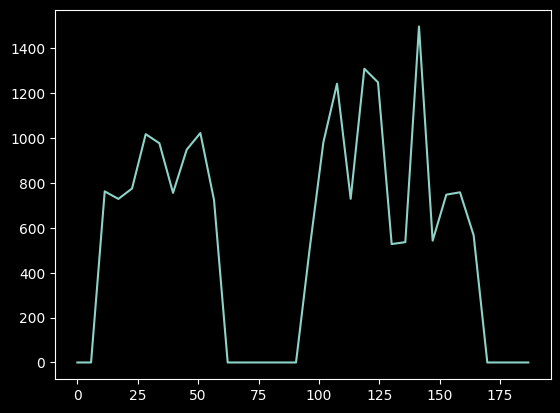

In [44]:
plt.plot(np.arange(0, (len(metrics[19]["dQ"][1])) * dh, dh), metrics[19]["dQ"][1])
plt.show()

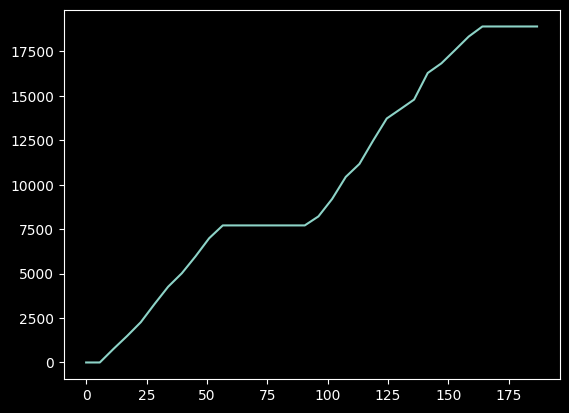

In [45]:
plt.plot(
    np.arange(0, (len(metrics[19]["dQ"][1])) * dh, dh), np.cumsum(metrics[19]["dQ"][1])
)
plt.show()